In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import BSpline
from scipy.linalg import block_diag
from scipy.special import ndtr
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def filterData(df):
    ''' Filters the option chain '''
    # drop low Bids and Asks 
    df = df[(df['Bid'] >= 0.001) | (df['Ask'] >= 0.001)]
    df[['Bid', 'Ask']] = np.where(df[['Bid', 'Ask']] < 0.001, np.nan, df[['Bid', 'Ask']])
    # drop wide Bid Ask spreads
    df = df[~(df['Ask'] > 4 * df['Bid'])]
    # Calculate Mid price for options with both valid Bid and Ask
    df['Mid'] = (df['Bid'] + df['Ask']) / 2
    
    # Format dates
    df[['Effective Date', 'Expiry Date', 'Last Trade Date']] = (
        df[['Effective Date', 'Expiry Date', 'Last Trade Date']]\
        .apply(pd.to_datetime, format='%m-%d-%Y')
        )   
    df['Tenor'] = np.round((df['Expiry Date'] - df['Effective Date']).dt.days / 365, 6)
    
    # Drop options with very stale last trade date
    df = df[df['Last Trade Date'] >= (df['Effective Date'] - pd.offsets.BusinessDay(n=5))]            
    
    df = df.sort_values(by=['Tenor', 'Strike'])
    tenors = df['Tenor'].unique()
    total = []
    for i in range(len(tenors)):
        t_options = df[df['Tenor']==tenors[i]].loc[:]
        # Drop options with spreads > 3 standard deviation of the average spread for given maturity
        t_options['Spread'] = t_options['Ask'] - t_options['Bid']
        mu = t_options['Spread'].mean()
        sd = t_options['Spread'].std()
        t_options = t_options[~(t_options['Spread'] >= mu + 3 * sd)].drop('Spread', axis=1)
        total.append(t_options)
    df = pd.concat(total, ignore_index=True)
    return df

In [3]:
def EstimateForwards(options, interp_DF):
    tenors = options['Tenor'].unique()
    df_fwd = pd.DataFrame()
    for i in range(len(tenors)):
        D = interp_DF(tenors[i]) # interpolate discount factor
        calls = df[(options['Tenor']==tenors[i]) & (options['Option Type']=='Call')].loc[:][['Strike', 'Bid', 'Ask', 'Mid']]
        puts = df[(options['Tenor']==tenors[i]) & (options['Option Type']=='Put')].loc[:][['Strike', 'Bid', 'Ask', 'Mid']]
        data = pd.merge(calls, puts, on='Strike')
        data = data.dropna(ignore_index=True)
        if len(data)==0: continue
        temp1 = data['Strike'] + (data['Bid_x'] - data['Bid_y']) / D
        temp2 = data['Strike'] + (data['Ask_x'] - data['Ask_y']) / D
        data['low_f'] = np.minimum(temp1, temp2)
        data['high_f'] = np.maximum(temp1, temp2)
        data['Mid_f'] = data['Strike'] + (data['Mid_x'] - data['Mid_y']) / D
        
        max_iter = 10
        j = 0
        fwd = np.mean(data['Mid_f'])
        while j <= max_iter:
            data1 = data[(data['Strike'] < fwd) & (data['low_f'] < fwd) &
                         (data['high_f'] > fwd)].tail(1)
            data2 = data[(data['Strike'] > fwd) & (data['low_f'] < fwd) &
                         (data['high_f'] > fwd)].head(1)
            if len(data1)==0 and len(data2)==0: break
            else:
                new_forward = pd.concat([data1, data2])['Mid_f'].mean()
                change = abs(new_forward - fwd) / fwd
                fwd = new_forward
                if len(data1)==1 and len(data2)==1 and \
                (data2.iloc[0,0] < new_forward or data1.iloc[0,0] > new_forward) : continue
                if change < 0.001: break
            j += 1
        df_fwd.loc[i, 'Tenor'] = tenors[i]
        df_fwd.loc[i, 'Forward'] = fwd
        df_fwd.loc[i, 'Disc Factor'] = D
        df_fwd = df_fwd.dropna()
    return df_fwd

In [4]:
def black_model(F, K, T, df, sigma, phi, calc_vega=False):
    """
    Black model for valuing vanilla european options
    phi = 1 for call options and -1 for put options
    """
    d1 = (np.log(F / K) + (0.5 * sigma**2 * T)) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    price = df * phi * (F * ndtr(phi * d1) - K * ndtr(phi * d2))
    if calc_vega: 
        vega = df * F * norm._pdf(d1) * np.sqrt(T)
        return price, vega
    return price


def implied_volatility(P, F, K, T, df, phi):
    max_iter = 200
    epsilon = 1.0e-5
    sigma = 0.5
    for i in range(max_iter):
        price, vega = black_model(F, K, T, df, sigma, phi, True)
        diff = P - price  
        if (abs(diff) < epsilon):
            return sigma
        sigma = sigma + diff/vega 
    return np.nan 

vec_bs_imp_vol = np.vectorize(implied_volatility)


## __Positivie Variance__

In [5]:
def PositiveVariance(tenor_b_splines, n_strikes):
    """
    Enforce positivity of variance for the first tenor at a discrete set of strikes.

    Only the first tenor is constrained because calendar arbitrage ensures 
    positivity for subsequent tenors.

    Parameters
    ----------
    tenor_b_splines : list of TenorSpline
        Precomputed splines per tenor.
    n_strikes : int
        Number of strikes at which to enforce the constraint.

    Returns
    -------
    A : np.ndarray
        Constraint matrix (n_strikes × n_bases*m)
    b : np.ndarray
        Upper bound vector (length n_strikes)
    """
    ts = tenor_b_splines[0]  # only the first tenor
    n_bases = ts.n_bases
    m = len(tenor_b_splines)
    A = np.zeros((n_strikes, n_bases * m))
    
    # Discretize strikes for positivity check
    zs = np.linspace(ts.interior_knots[0], ts.interior_knots[-1], n_strikes)
    
    # Fill first block with negative spline values for inequality: -f(x) <= -epsilon
    A[:, :n_bases] = -ts.spline(zs)
    
    # Small positive threshold
    b = np.full(n_strikes, -1e-6)
    
    return A, b

## __Linear Wing Extrapolation__

In [6]:
def LinearWingExtrapolation(tenor_b_splines):
    """
    Construct linear wing extrapolation constraint matrix A and RHS b.

    Args:
        tenor_splines (list of TenorSpline): precomputed splines per tenor.

    Returns:
        A (np.ndarray): constraint matrix (2*m × n_bases*m)
        b (np.ndarray): RHS vector of zeros
    """
    
    m = len(tenor_b_splines) 
    n_bases = tenor_b_splines[0].n_bases
    A = np.zeros((2 * m, n_bases * m))
    b = np.zeros(2 * m)
    
    for i, ts in enumerate(tenor_b_splines):
        z0, zn = ts.interior_knots[0], ts.interior_knots[-1] # Endpoints of the tenor spline
        # 2×n_bases block: second derivatives at left and right ends
        block = np.vstack([
            ts.second_derivative_spline(z0),
            ts.second_derivative_spline(zn)
        ])
        A[2*i:2*i+2, n_bases*i:n_bases*(i+1)] = block
    
    return A, b

## __Upward Sloping Wings__

In [7]:
def UpwardSlopingWings(tenor_b_splines):
    """
    Construct constraints enforcing upward-sloping wings for each tenor.
    
    Parameters
    ----------
    tenor_b_splines : list of TenorSpline
        List of precomputed spline objects per tenor.
    
    Returns
    -------
    A : np.ndarray
        Constraint matrix (2*m × n_bases*m)
    b : np.ndarray
        RHS vector for inequalities (length 2*m)
    """
    m = len(tenor_b_splines)
    n_bases = tenor_b_splines[0].n_bases
    A = np.zeros((2 * m, n_bases * m))
    b = np.full(2 * m, -1e-6)
    for i, ts in enumerate(tenor_b_splines):
        z0, zn = ts.interior_knots[0], ts.interior_knots[-1] # Endpoints of the tenor spline
        block = np.vstack([
            ts.first_derivative_spline(z0),
            -ts.first_derivative_spline(zn)
        ])
        A[2*i:2*i+2, n_bases*i:n_bases*(i+1)] = block
    
    return A, b

## __Roger Lee Moment__

In [8]:
def RogerLeeMoment(tenor_b_splines, tenors, est_atmf_vols):
    """
    Roger Lee maximum tail skew constraints.
    
    Parameters
    ----------
    tenor_b_splines : list of TenorSpline
    tenors : array_like
        Tenor expiries (T)
    est_atmf_vols : array_like
        Estimated ATM volatilities per tenor (σ*)
    
    Returns
    -------
    A : np.ndarray
        Constraint matrix (2*m × n_bases*m)
    b : np.ndarray
        RHS vector (length 2*m)
    """
    
    m = len(tenor_b_splines)
    n_bases = tenor_b_splines[0].n_bases
    A = np.zeros((2 * m, n_bases * m))
    b = np.full(2*m, 1 - 1e-8)
    factors = np.sqrt(tenors) / (2 * est_atmf_vols)
    for i, ts in enumerate(tenor_b_splines):
        z0, zn = ts.interior_knots[0], ts.interior_knots[-1] # Endpoints of the tenor spline
        block = np.vstack([
            -factors[i] * ts.first_derivative_spline(z0),
             factors[i] * ts.first_derivative_spline(zn)
        ])
        A[2*i:2*i+2, n_bases*i:n_bases*(i+1)] = block
    
    return A, b

## __No Calendar Spread Arbitrage__

In [9]:

def NoCalendarSpreadArbitrage(tenor_b_splines, n_strikes, knots, k_knots, tenors, est_atmf_vols):
    """
    Build no-calendar-arbitrage constraints (A @ coeffs <= b).

    For each adjacent tenor pair (T1,T2):
      - Row 0            : left wing slope (derivatives), small slack -eps
      - Rows 1..n_strikes: interior total variance monotonicity
                           -T1*v(z1,T1) + T2*v(z2,T2) <= 0
      - Row n_strikes+1  : right wing slope (derivatives), small slack -eps

    Notes:
    - spline parameterizes per-unit variance v(z,T)
    - total variance = T * v(z,T)
    - Wing slopes scaled with sqrt(T)/sigma* per Roger-Lee bounds
    - Interior rows scaled by tenor to enforce total variance constraint
    """  
    
    m = len(tenor_b_splines)
    n_bases = tenor_b_splines[0].n_bases
    n_constraints = m - 1
    block_size = n_strikes + 2  # wing rows + interior rows
    A = np.zeros((n_constraints * block_size, m * n_bases))
    
    # Scaling factors for wing slope constraints
    factors1 = np.sqrt(tenors[:-1]) / est_atmf_vols[:-1]
    factors2 = np.sqrt(tenors[1:])  / est_atmf_vols[1:]
       
    for i in range(n_constraints):
        T1, T2 = tenors[i], tenors[i + 1]
        ts1, ts2 = tenor_b_splines[i], tenor_b_splines[i + 1]
        row0 = i * block_size
        
        # wing: left endpoints slope constraint
        block = np.concatenate([
            -factors1[i] * ts1.first_derivative_spline(ts1.interior_knots[0]),
             factors2[i] * ts2.first_derivative_spline(ts2.interior_knots[0])
        ])
        A[row0, n_bases*i : n_bases*(i+2)] = block
        
        # interior overlap: total variance monotonicity ---
        start = max(k_knots[i,0], k_knots[i+1,0])
        end   = min(k_knots[i,-1], k_knots[i+1,-1])
        if end > start:
            k_grid = np.linspace(start, end, n_strikes)
            z_grid1 = k_grid / (est_atmf_vols[i]   * np.sqrt(T1))
            z_grid2 = k_grid / (est_atmf_vols[i+1] * np.sqrt(T2))
            
            B1 = ts1.spline(z_grid1)  # shape (n_strikes, n_bases)
            B2 = ts2.spline(z_grid2)  # shape (n_strikes, n_bases)
            blocks = np.hstack([T1 * B1, -T2 * B2])
            A[row0+1 : row0+1+n_strikes, n_bases*i : n_bases*(i+2)] = blocks

        # wing: right endpoints slope constraint
        block = np.concatenate([
            -factors1[i] * ts1.first_derivative_spline(ts1.interior_knots[-1]),
             factors2[i] * ts2.first_derivative_spline(ts2.interior_knots[-1])
        ])
        A[row0 + block_size - 1, n_bases*i : n_bases*(i+2)] = block
        
    # RHS vector        
    b = np.zeros(len(A))
    eps = 1e-7
    idx = np.arange(n_constraints) * block_size
    idx = np.concatenate([idx, idx + block_size - 1])
    b[idx] = -eps
    
    return A, b

## __No Butterfly Arbitrage Helper Functions__

In [10]:
def pdf_Smin(v, T, atmf_vol_est, m):
    """
    Returns the value of Smin and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    """
    term1 = (0.25 * v**2 * T**2 + v*T)
    term2 = term1**0.5
    term3 = m**2 - term1
    term4 = (-T - 0.5 * v * T**2)
    term5 = 2 * term2
    term6 = -m - term2
    term7 = ((term3 * (term4 / term5)) - (term6 * term4)) / term3**2
    term8 = (-2 * T**0.5) / atmf_vol_est
    val = (v * term8) * (term6 / term3)
    der = (v * term8 * term7) + ((term6 / term3) * term8)
    return val, der


def pdf_Smax(v, T, atmf_vol_est, m):
    """
    Returns the value of Smax and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    """
    term1 = (0.25 * v**2 * T**2 + v*T)
    term2 = term1**0.5
    term3 = m**2 - term1
    term4 = (-T - 0.5 * v * T**2)
    term5 = 2 * term2
    term6 = m - term2
    term7 = ((term3 * (term4 / term5)) - (term6 * term4)) / term3**2
    term8 = (2 * T**0.5) / atmf_vol_est
    val = (v * term8) * (term6 / term3)
    der = (v * term8 * term7) + ((term6 / term3) * term8)
    return val, der


def cdf_sMin(v, T, atmf_vol_est, m, d1, n_d1, n_d2, N_d2):
    """
    Returns the value of Smax and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    d1 : (float): Black Scholes d1 at the reference variance input
    n_d1 : (float): standard normal pdf at d1
    n_d2 : (float): standard normal pdf at d2
    N_d2 : (float): standard normal cdf at d2
    """
    term1 = ( -n_d2 * (2*m - v*T) + (1 - N_d2) * d1 * (2*m + v*T) ) / (n_d1 * 4 * v * (v * T)**0.5)
    term2 = (1 - N_d2) / n_d1
    term3 = np.exp(m) / atmf_vol_est
    term4 = v**0.5
    term5 = -term3 / term4
    term6 = -2 * term3 * term4
    der = term6 * term1 + term2 * term5
    val = term6 * term2
    return val, der


def cdf_sMax(v, T, atmf_vol_est, m, d1, n_d1, n_d2, N_d2):
    """
    Returns the value of Smax and it's derivative w.r.t v at the reference variance input
    Parameters
    ----------
    v : (float): variance
    T : (float): tenor
    atmf_vol_est : (float): estimated ATMF vol for the given tenor 
    m : (float): Log moneyness Log(K/F)
    d1 : (float): Black Scholes d1 at the reference variance input
    n_d1 : (float): standard normal pdf at d1
    n_d2 : (float): standard normal pdf at d2
    N_d2 : (float): standard normal cdf at d2
    """
    term1 = ( n_d2 * (2*m - v*T) + N_d2 * d1 * (2*m + v*T) ) / (n_d1 * 4 * v * (v * T)**0.5)
    term2 = N_d2 / n_d1
    term3 = np.exp(m) / atmf_vol_est
    term4 = v**0.5
    term5 = term3 / term4
    term6 = 2 * term3 * term4
    der = term6 * term1 + term2 * term5
    val = term6 * term2
    return val, der


def PrepareButterfly(weights, tenor_b_splines, n_strikes, est_atmf_vols, tenors):   
    m = len(tenor_b_splines)
    n_bases = tenor_b_splines[0].n_bases
    
    v_refs = np.empty((m, n_strikes))
    s_refs = np.empty((m, n_strikes))
    c_refs = np.empty((m, n_strikes))
    d1_refs = np.empty((m, n_strikes))
    d2_refs = np.empty((m, n_strikes))
    z_grids = np.empty((m, n_strikes))
    k_grids = np.empty((m, n_strikes))
    
    for i, ts in enumerate(tenor_b_splines):
        T = tenors[i]
        sigma_est = est_atmf_vols[i]
        v_est = sigma_est**2
        wts = weights[i*n_bases : (i+1)*n_bases]
        
        z_grid = np.linspace(ts.interior_knots[0], ts.interior_knots[-1], n_strikes)
        k_grid = z_grid * (sigma_est * T**0.5)  # Ln(K/F)
        
        v_refs[i] = ts.spline(z_grid) @ wts
        s_refs[i] = (1 / v_est) * ts.first_derivative_spline(z_grid) @ wts
        c_refs[i] = (1 / v_est) * ts.second_derivative_spline(z_grid) @ wts
        
        # calculate d1 and d2
        temp1 = v_refs[i] * T
        temp2 = np.sqrt(temp1)
        d1_refs[i] = (-k_grid + temp1 / 2) / temp2
        d2_refs[i] = d1_refs[i] - temp2
        z_grids[i] = z_grid
        k_grids[i] = k_grid
    
    return z_grids, k_grids, v_refs, s_refs, c_refs, d1_refs, d2_refs


## __No Butterfly Arbitrage PDF__

In [13]:
def NoButterflyArbitrage(tenor_b_splines, z_grids, k_grids, v_refs, s_refs, d1_refs, d2_refs, tenors, est_atmf_vols):
    """
    Parameters
    ----------
    tenor_b_splines : list of TenorSpline
    z_grids : (np.ndarray): array of z values at each point on grid where constraint is enforced
    k_grids : (np.ndarray): array of k values at each point on grid where constraint is enforced
    v_refs : (np.ndarray): reference variance at each point on grid
    s_refs : (np.ndarray): reference skew at each point on grid
    d1_refs : (np.ndarray): reference black scholes d1 at each point on grid
    d2_refs : (np.ndarray): reference black scholes d2 at each point on grid
    tenors : (np.ndarray): array of option tenors
    est_atmf_vols : (np.ndarray): array of estimated ATMF vol for each tenor
    """
    
    m = len(tenor_b_splines)
    n_bases = tenor_b_splines[0].n_bases
    n_strikes = len(z_grids[0])
    A = np.zeros((m * n_strikes, n_bases * m))
    b = np.empty(m * n_strikes)
    
    for i, ts in enumerate(tenor_b_splines):
        z0, zn = ts.interior_knots[0], ts.interior_knots[-1]
        t = tenors[i]
        sigma_est = est_atmf_vols[i]
        v_est = sigma_est**2
        row0 = i * n_strikes
        
        # wing: left endpoints constraint
        s_min, s_min_der = pdf_Smin(v_refs[i,0], t, sigma_est, k_grids[i,0])
        block = s_min_der * ts.spline(z0) - (1 / v_est) * ts.first_derivative_spline(z0)
        A[row0, n_bases*i : n_bases*(i+1)] = block
        b[row0] = (s_min_der * v_refs[i,0]) - s_min
        
        # Internal knots
        v_ref = v_refs[i, 1 : -1]
        s_ref = s_refs[i, 1 : -1]
        d1_ref = d1_refs[i, 1 : -1]
        d2_ref = d2_refs[i, 1 : -1]
        z_grid = np.linspace(z0, zn, n_strikes)[1 : -1]

        beta0 = (
            (v_est * s_ref**2) / (2 * v_ref) + 
            sigma_est * np.sqrt(t) * s_ref -
            2 * (1 + d1_ref * (sigma_est / v_ref**0.5) * s_ref + 
            d1_ref * d2_ref * s_ref**2 * (v_est / (4 * v_ref)))
            )
        beta1 = (
            (v_est * s_ref / v_ref) + sigma_est * t**0.5 -
            2 * ((d1_ref * sigma_est / (v_ref**0.5)) + 
            d1_ref * d2_ref * s_ref * v_est / (2 * v_ref))
            )
        beta2 = (
            (s_ref / v_ref) * ( -v_est * s_ref / (2 * v_ref) + 
            (2 * -k_grids[i, 1:-1] / (v_ref * t)) * (sigma_est * t**0.5 + 
            (-k_grids[i, 1:-1] / 2) * s_ref * v_est / v_ref))
            )
        
        block = (
            (1 / v_est) * (ts.first_derivative_spline(z_grid).T * beta1).T +
            (ts.spline(z_grid).T * beta2).T -
            (1 / v_est) * ts.second_derivative_spline(z_grid)
            )
        
        A[row0+1 : row0+n_strikes-1, n_bases*i : n_bases*(i+1)] = block
        b[row0+1 : row0+n_strikes-1] = (beta2 * v_ref) + (beta1 * s_ref) - beta0

        # wing: right endpoints constraint
        s_max, s_max_der = pdf_Smax(v_refs[i,-1], t, sigma_est, k_grids[i,-1])
        block = (1 / v_est) * ts.first_derivative_spline(zn) - s_max_der * ts.spline(zn)
        A[row0+n_strikes-1, n_bases*i : n_bases*(i+1)] = block
        b[row0+n_strikes-1] = s_max - (s_max_der * v_refs[i,-1])
        
    return A, b

## __Calculate PDF__

In [14]:
def CalculatePDF(k_grid, d1_refs, d2_refs, v_refs, s_refs, c_refs, est_atmf_vols, tenors, forwards):
    
    sigma_est = est_atmf_vols[:, None]
    T = tenors[:, None]
    T_sqrt = np.sqrt(T)
    F = forwards[:, None]
    
    K_grid = np.exp(k_grid) * F
    K_grid_sq = K_grid**2
    sigmas = np.sqrt(v_refs)
    
    sigma_der1 = sigma_est * s_refs / (2.0 * sigmas * T_sqrt * K_grid)
    sigma_der2 = (
        (c_refs / (2.0 * sigmas * T * K_grid_sq)) - 
        (sigma_est**2 * s_refs**2 / (4.0 * sigmas**3 * T * K_grid_sq)) -
        (sigma_est * s_refs / (2.0 * sigmas * T_sqrt * K_grid_sq))
        )
    
    term1 = (1.0 / (K_grid * sigmas * T_sqrt)) 
    term2 = (2.0 * d1_refs * sigma_der1 / sigmas)
    term3 = d1_refs * d2_refs * K_grid * T_sqrt * sigma_der1**2 / sigmas
    term4 = K_grid * T_sqrt * sigma_der2
    
    n_d2_refs = norm._pdf(d2_refs)
    pdfs = n_d2_refs * (term1 + term2 + term3 + term4)
    
    return pdfs

## __Strike Regularization__

In [16]:
def StrikeRegulariztion(tenor_b_splines, est_atmf_vols):
    m = len(tenor_b_splines)
    n_bases = tenor_b_splines[0].n_bases
    rows_per_tenor = len(tenor_b_splines[0].interior_knots) - 1
    P = np.zeros((m * rows_per_tenor, m * n_bases))
    for i, ts in enumerate(tenor_b_splines):
        col0 = i * n_bases
        row0 = i * rows_per_tenor
        v_est = est_atmf_vols[i]**2
        zs = ts.interior_knots
        cs = (1 / v_est) * ts.second_derivative_spline(zs)
        block = cs[:-1] - cs[1:]
        P[row0:row0+rows_per_tenor, col0:col0+n_bases] = block
    return P

## __Read and Process Option Chain__

In [18]:
df = pd.read_csv('option_chain.csv')
df = filterData(df)
# Get Forward Prices
sofr = pd.read_csv('option_chain.csv')
interp_DF = lambda t: np.exp(np.interp(t, sofr['T'], np.log(sofr['DF'])))
df_fwd = EstimateForwards(df, interp_DF)
df = df[df['Tenor'].isin(df_fwd['Tenor'])]
df = df.merge(df_fwd, how='left', on='Tenor')

# Select OTM Options
df = pd.concat([
    df[(df['Option Type']=='Call') & (df['Strike'] > df['Forward'])],
    df[(df['Option Type']=='Put') & (df['Strike'] < df['Forward'])]
    ]).sort_values(by=['Tenor', 'Strike'], ignore_index=True)


tenors = df['Tenor'].unique()
volTypes = ['Bid', 'Ask', 'Mid']
total = []
for i in range(len(tenors)):
    t_options = df[df['Tenor']==tenors[i]]
    t_options = t_options.sort_values(by='Strike')
    # calculate implied volatilities
    for j in range(len(volTypes)):
        imp_vols = vec_bs_imp_vol(
        t_options[volTypes[j]].to_numpy(),
        t_options['Forward'].to_numpy(),
        t_options['Strike'].to_numpy(),
        t_options['Tenor'].to_numpy(),
        t_options['Disc Factor'].to_numpy(),
        np.where(t_options['Option Type']=='Call', 1, -1)
        )
        t_options[volTypes[j] + 'Vol'] = imp_vols
    t_options = t_options[~(t_options[['BidVol','AskVol', 'MidVol']].isnull().all(axis=1))]
    t_options[['BidVar','AskVar', 'MidVar']] = t_options[['BidVol','AskVol', 'MidVol']]**2
    t_options['k'] = np.log(t_options['Strike'] / t_options['Forward'])
    # Get counts
    t_options['N_ask'] = t_options['AskVol'].count()
    t_options['N_bid'] = t_options['BidVol'].count()
    t_options['N_mid'] = t_options['MidVol'].count()
    # Calculate Weights
    q_j = np.sum(1 / (t_options['AskVar'] - t_options['BidVar'])**2)
    t_options['Weight'] = q_j * (1 / (t_options['AskVol'] - t_options['BidVol'])) / np.sum(1 / (t_options['AskVol'] - t_options['BidVol']))
    # Above Ask Weights
    t_options['Ask Weight'] = q_j * t_options['AskVar'] / np.sum(t_options['AskVar'])
    # Below Bid Weights
    t_options['Bid Weight'] = q_j * t_options['BidVar'] / np.sum(t_options['BidVar'])
    # Estimated ATMF Volatility
    temp = t_options[['k', 'MidVol']].dropna().drop_duplicates(subset='k')
    s = InterpolatedUnivariateSpline(temp['k'], temp['MidVol'], k=1)
    t_options['Sigma Est'] = float(s(0.0))
    # Calculate the scaled log moneyness (z)
    t_options['z'] = t_options['k'] / (t_options['Sigma Est'] * t_options['Tenor']**0.5)
    t_options.update(t_options[['Weight', 'Ask Weight', 'Bid Weight']].fillna(0.))
    t_options.update(t_options[['BidVar','AskVar', 'MidVar']].fillna(0.))
    total.append(t_options)
df = pd.concat(total, ignore_index=True)

## __Generate Cubic-Spline knots and B-Spline objects__

In [21]:
def generate_knots(k_min, k_max, N):
    assert N >= 7, "Need at least 7 knots to include endpoints and ATM"
    if N % 2 == 0: N += 1  
    N_atm = min(9, N - 4)
    remaining = N - N_atm 
    k1 = np.linspace(k_min, -0.2, remaining//2, endpoint=False)
    k2 = np.linspace(-0.2, 0.2, N_atm)
    k3 = np.linspace(k_max, 0.2, remaining//2, endpoint=False)[::-1] 
    knots = np.concatenate((k1, k2, k3))
    return knots


class TenorSpline:
    """
    Represents a B-spline for a single tenor, with precomputed first and second derivatives.
    
    Attributes:
        spline: BSpline object
        first_derivative_spline: BSpline object for first derivative
        second_derivative_spline: BSpline object for second derivative
    """
    def __init__(self, interior_knots, coeffs, k):
        knots = np.concatenate(([interior_knots[0]] * k, interior_knots, [interior_knots[-1]] * k))
        self.interior_knots = interior_knots
        self.n_bases = len(coeffs)
        self.k = k
        self.spline = BSpline(knots, coeffs, k)
        self.first_derivative_spline = self.spline.derivative(nu=1)
        self.second_derivative_spline = self.spline.derivative(nu=2)
        

temp = df.groupby('Tenor')
tenors = np.array(list(temp.groups.keys()))
expiries = np.array([temp.get_group(t)['Expiry Date'].iloc[0] for t in tenors])
forwards = temp['Forward'].first().to_numpy()
est_atmf_vols = temp['Sigma Est'].first().to_numpy()
scale = est_atmf_vols * np.sqrt(tenors)
min_ks = temp['k'].min().to_numpy()
max_ks = temp['k'].max().to_numpy()


# Get minimum and maximum moneyness that defines spline
lower = np.minimum.accumulate(np.minimum(-0.5, np.floor(min_ks / 0.2) * 0.2))
upper = np.maximum.accumulate(np.maximum(0.5, np.ceil(max_ks / 0.2) * 0.2))

# Generate Cubic Spline Knots and B-Spline objects
n_knots = 25
k_knots = np.array([ generate_knots(k_min, k_max, n_knots) for k_min, k_max in zip(lower,upper) ])
z_knots = (k_knots.T / scale).T
k = 3
n_bases = n_knots + k - 1
coeffs = np.eye(n_bases) # identity matrix: each column selects one B-spline basis function
tenor_b_splines = [TenorSpline(z_knots[i], coeffs, k) for i in range(len(tenors))]

## __Convex Volatility Interpolation Volatility Surface Fitter__

In [25]:
class CVIVolatilitySurfaceFitter:
    def __init__(self, tenor_b_splines, k_knots, est_atmf_vols, tenors, expiries, forwards, reg_factor=0.05):
        self.tenor_b_splines = tenor_b_splines
        self.k_knots = k_knots
        self.est_atmf_vols = est_atmf_vols
        self.tenors = tenors
        self.expiries = expiries
        self.forwards = forwards
        self.reg_factor = reg_factor
        scale = est_atmf_vols * np.sqrt(tenors)       
        self.z_knots = (k_knots.T / scale).T
        self.weights=None
        
    def prepare_data(self, df, n_strikes_pos=100, n_strikes_cal=100):
        # Build P matrix
        P = []
        for i, ts in enumerate(self.tenor_b_splines):
            zs = df[df['Tenor']==tenors[i]]['z'].to_numpy(dtype=float)
            P.append(ts.spline(zs))
        self.P = block_diag(*P)

        # Strike regularization
        self.P_reg = StrikeRegulariztion(self.tenor_b_splines, self.est_atmf_vols)

        # Targets and weights
        self.y1 = df['MidVar'].to_numpy()
        self.w1 = np.sqrt(df['Weight'] / df['N_mid']).to_numpy()
        self.y2 = df['AskVar'].to_numpy()
        self.w2 = np.sqrt(df['Ask Weight'] / df['N_ask']).to_numpy()
        self.y3 = df['BidVar'].to_numpy()
        self.w3 = np.sqrt(df['Bid Weight'] / df['N_bid']).to_numpy()
        self.volTenors = df['Tenor'].to_numpy()
        self.volMoneyness = df['k'].to_numpy()
    

        # Default constraints
        A1, b1 = PositiveVariance(self.tenor_b_splines, n_strikes_pos)
        A2, b2 = UpwardSlopingWings(self.tenor_b_splines)
        A3, b3 = RogerLeeMoment(self.tenor_b_splines, self.tenors, self.est_atmf_vols)
        A4, b4 = NoCalendarSpreadArbitrage(self.tenor_b_splines, n_strikes_cal, self.z_knots, self.k_knots, self.tenors, self.est_atmf_vols)
        self.A_ineq = np.concatenate((A1, A2, A3, A4))
        self.b_ineq = np.concatenate((b1, b2, b3, b4))
        self.Aeq, self.beq = LinearWingExtrapolation(tenor_b_splines)

    def solve_vol_fit(self, P, y1, w1, y2, w2, y3, w3, P_reg, reg_factor, Aeq=None, beq=None, A_ineq=None, b_ineq=None):
        """
        Solve the constrained vol surface fitting problem.
    
        Parameters
        ----------
        P : ndarray
            Block-diagonal spline evaluation matrix.
        y1, y2, y3 : ndarray
            Mid, Ask, Bid variances.
        w1, w2, w3 : ndarray
            Corresponding weights.
        P_reg : ndarray
            Strike regularization matrix.
        reg_factor : float
            L1 regularization coefficient.
        Aeq, beq : ndarray or None
            Equality constraints (optional).
        A_ineq, b_ineq : ndarray or None
            Inequality constraints (optional).
    
        Returns
        -------
        x.value : ndarray
            Optimized spline coefficients.
        """
        n_coeff = P.shape[1]
        x = cp.Variable(n_coeff)
    
        # Least-squares penalties
        cost_mid = cp.sum_squares(cp.multiply(P @ x - y1, w1))
        cost_above = cp.sum_squares(cp.multiply(cp.maximum(P @ x - y2, 0.0), w2))
        cost_below = cp.sum_squares(cp.multiply(cp.maximum(y3 - P @ x, 0.0), w3))
    
        # Strike regularization (L1)
        cost_reg = reg_factor * cp.norm(P_reg @ x, 1)
    
        # Total cost
        total_cost = cost_mid + cost_above + cost_below + cost_reg
    
        # Constraints
        constraints = []
        if Aeq is not None and beq is not None:
            constraints.append(Aeq @ x == beq)
        if A_ineq is not None and b_ineq is not None:
            constraints.append(A_ineq @ x <= b_ineq)
    
        # Solve
        prob = cp.Problem(cp.Minimize(total_cost), constraints)
        prob.solve(solver=cp.CLARABEL)
    
        if prob.status not in ["optimal", "optimal_inaccurate"]:
            raise ValueError(f"Solver failed with status: {prob.status}")
    
        return x.value
    
    def _initial_fit(self):
        """
        Solve the initial quadratic programming (QP) problem without butterfly constraints.
        Fits the spline coefficients to mid/ask/bid variance data using weighted least squares
        and strike regularization, subject to default linear equality and inequality constraints.
        This is the first step before enforcing butterfly arbitrage.
        """
        self.weights = self.solve_vol_fit(self.P, self.y1, self.w1,
                                     self.y2, self.w2,
                                     self.y3, self.w3,
                                     self.P_reg, self.reg_factor,
                                     self.Aeq, self.beq,
                                     self.A_ineq, self.b_ineq)
        
    def _enforce_butterfly(self, max_iter, n_strikes_butterfly):
        """
        Iteratively enforce no-butterfly arbitrage on the fitted surface.
        Uses the current spline weights to prepare strike and transformed grids,
        computes implied PDFs, and adds linearized butterfly constraints where needed.
        Re-solves the quadratic program until all PDFs are positive or the maximum
        number of iterations is reached.
        """

        for _ in range(max_iter):
            # Prepare grids around current solution
            res = PrepareButterfly(self.weights, self.tenor_b_splines,
                                   n_strikes_butterfly, self.est_atmf_vols, self.tenors)
            z_grids, k_grids, v_refs, s_refs, c_refs, d1_refs, d2_refs = res
            
            # Compute PDFs
            pdfs = CalculatePDF(k_grids, d1_refs, d2_refs, v_refs, s_refs,
                                c_refs, self.est_atmf_vols, self.tenors, self.forwards)
    
            # Stop if no violations
            if np.all(pdfs > 0.0):
                break
            
            # Otherwise, generate linearized butterfly constraints
            A5, b5 = NoButterflyArbitrage(self.tenor_b_splines, z_grids, k_grids,
                                          v_refs, s_refs, d1_refs, d2_refs,
                                          self.tenors, self.est_atmf_vols)

            # Solve QP with extra constraints
            self.weights = self.solve_vol_fit(
                self.P, self.y1, self.w1,
                self.y2, self.w2,
                self.y3, self.w3,
                self.P_reg, self.reg_factor,
                self.Aeq, self.beq,
                np.concatenate([self.A_ineq, A5]),
                np.concatenate([self.b_ineq, b5])
            )

    def solve(self, max_iter=2, n_strikes_butterfly=100):
        """Public method: runs full workflow and returns final weights."""
        self._initial_fit()             # internal initial fit
        self._enforce_butterfly(max_iter, n_strikes_butterfly)  # internal iterative linearization
        return self.weights

    def plot_surface_and_pdf(self, n_strikes=100):

        # Prepare grids
        res = PrepareButterfly(self.weights, self.tenor_b_splines,
                               n_strikes, self.est_atmf_vols, self.tenors)
        z_grids, k_grids, v_refs, s_refs, c_refs, d1_refs, d2_refs = res
        
        # Compute PDFs
        pdfs = CalculatePDF(k_grids, d1_refs, d2_refs, v_refs, s_refs,
                            c_refs, self.est_atmf_vols, self.tenors, self.forwards)
        
        # Calculate fitted variances
        n_bases = self.tenor_b_splines[0].n_bases
        weights = self.weights
        variances = np.empty_like(z_grids, dtype=float)
        for i, ts in enumerate(self.tenor_b_splines):
            wts = weights[i * n_bases : (i + 1) * n_bases]
            variances[i] = ts.spline(z_grids[i]) @ wts
    
        # Plot per tenor
        for i, tenor in enumerate(tenors):
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
    
            pos = self.volTenors == tenor
            exp_date = self.expiries[i].strftime('%m-%d-%Y')
            spline_vols = np.sqrt(variances[i])
    
            # Market vols
            ks = self.volMoneyness[pos]
            ax1.plot(ks, np.sqrt(self.y2[pos]), 'v', ms=2, color='grey', label='Ask Vols')
            ax1.plot(ks, np.sqrt(self.y1[pos]), 'o', ms=2, color='red', label='Mid Vols')
            ax1.plot(ks, np.sqrt(self.y3[pos]), '^', ms=2, color='grey', label='Bid Vols')
    
            # Fitted spline
            ax1.plot(k_grids[i], spline_vols, '-', color='green', lw=1, label='Fitted Vols')
    
            # PDF
            ax2.plot(k_grids[i], pdfs[i], color='#c071fe')
            ax2.fill_between(k_grids[i], pdfs[i], color='#c071fe', alpha=0.7, label='PDF')
    
            # Labels, grid, legend
            ax1.set_xlabel('log(K/F)')
            ax1.set_ylabel('Volatility')
            ax2.set_yticks([])
            fig.suptitle(f'Expiry: {exp_date}', fontsize=15)
            ax1.grid(True, which='both', axis='both')
            ax1.legend(loc='upper right')
            ax2.legend(loc='center left')
    
            plt.show()

    def get_spline_parameters(self):
        n_bases = self.tenor_b_splines[0].n_bases
        weights = self.weights
        results = {}
        for i, ts in enumerate(self.tenor_b_splines):
            wts = weights[i * n_bases : (i + 1) * n_bases]
            atm_var = ts.spline(0.0) @ wts
            atm_skew = ts.first_derivative_spline(0.0) @ wts
            convexities = ts.second_derivative_spline(self.z_knots[i]) @ wts
            
            series_data = {
            "ATM_var": atm_var,
            "ATM_skew": atm_skew,
            }
            for k, cv in zip(self.k_knots[i], convexities):
                series_data[f"c(k={k:.3f})"] = cv
                
            results[self.tenors[i]] = pd.Series(series_data)

        return results

## __Run Solver__

In [27]:
volFitter = CVIVolatilitySurfaceFitter(tenor_b_splines, k_knots, est_atmf_vols, tenors, expiries, forwards)
volFitter.prepare_data(df)
wts = volFitter.solve()
parameters = volFitter.get_spline_parameters()

## __First Tenor Parameters__

In [32]:
first_tenor, first_series = next(iter(parameters.items()))
print("Tenor:", first_tenor)
display(first_series)

Tenor: 0.019178


ATM_var        1.080249e-02
ATM_skew      -2.429949e-03
c(k=-0.500)   -2.220446e-16
c(k=-0.463)   -9.466868e-04
c(k=-0.425)   -9.466868e-04
c(k=-0.388)   -9.466868e-04
c(k=-0.350)   -6.888318e-05
c(k=-0.312)    4.752002e-04
c(k=-0.275)    8.101432e-04
c(k=-0.237)    1.953102e-03
c(k=-0.200)    1.239801e-03
c(k=-0.150)    1.239801e-03
c(k=-0.100)    1.239801e-03
c(k=-0.050)    2.769832e-03
c(k=0.000)     1.915743e-03
c(k=0.050)     2.613616e-03
c(k=0.100)     1.383166e-03
c(k=0.150)     1.383166e-03
c(k=0.200)     1.230878e-03
c(k=0.237)     1.150147e-03
c(k=0.275)     1.062739e-03
c(k=0.312)     9.674900e-04
c(k=0.350)     8.562489e-04
c(k=0.388)     7.234656e-04
c(k=0.425)     5.520440e-04
c(k=0.463)     3.940722e-04
c(k=0.500)    -2.220446e-16
dtype: float64

## __Plotting__

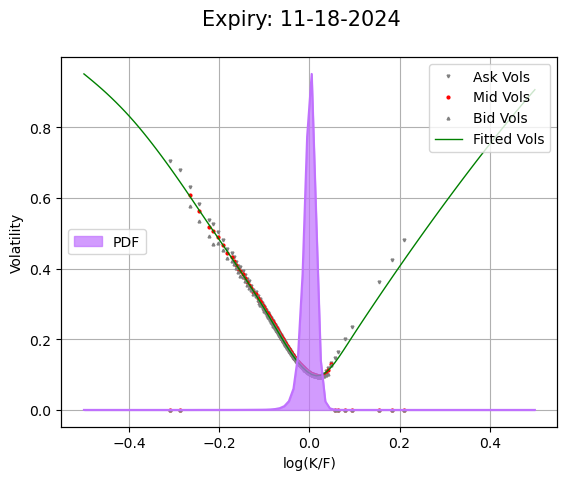

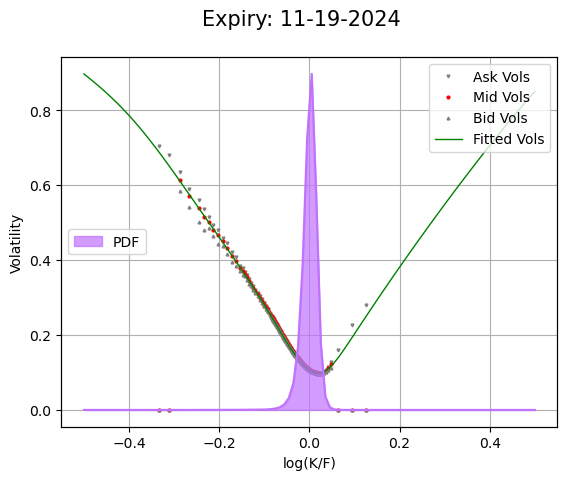

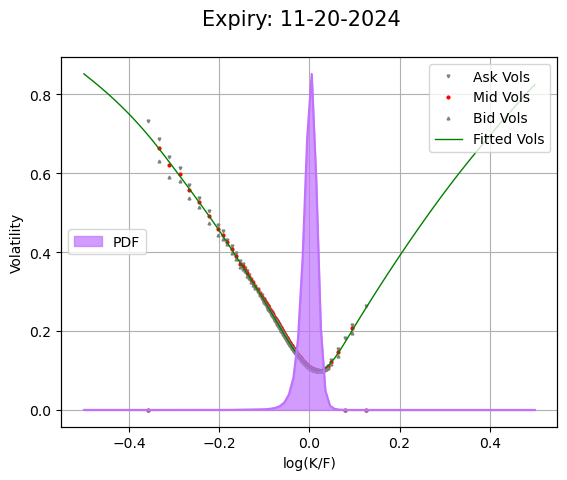

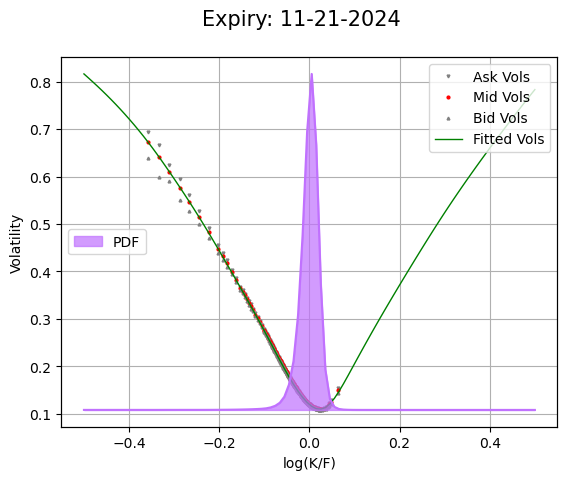

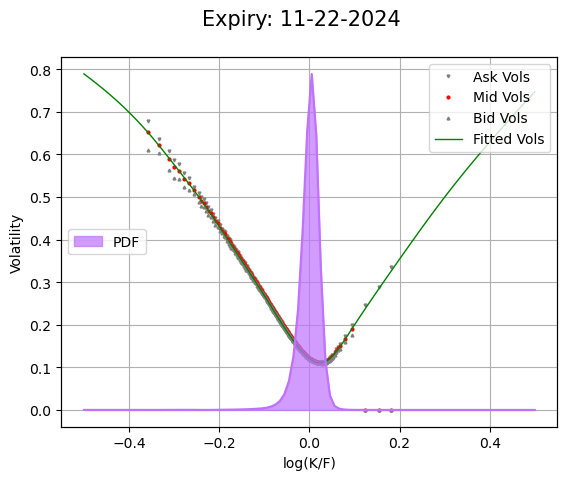

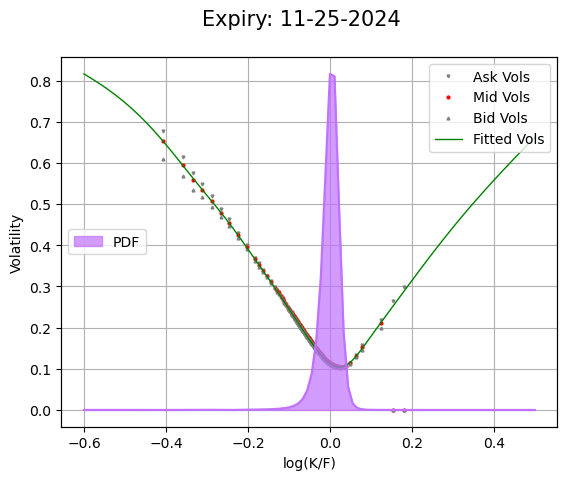

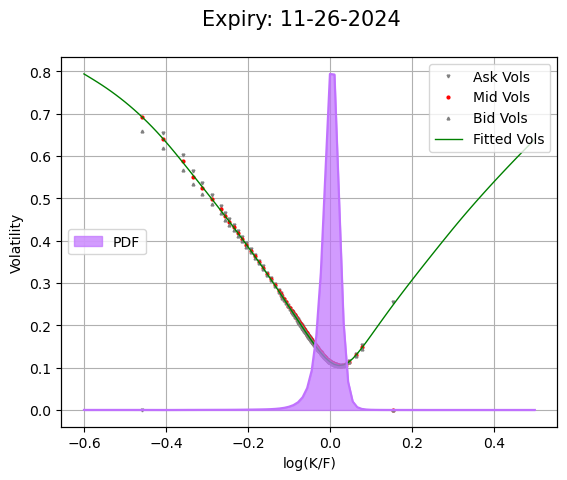

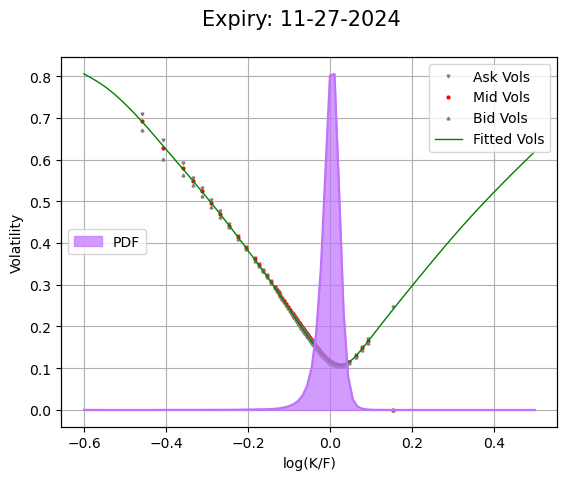

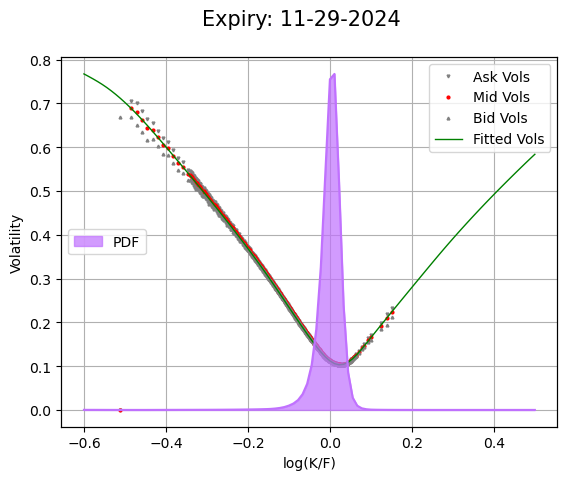

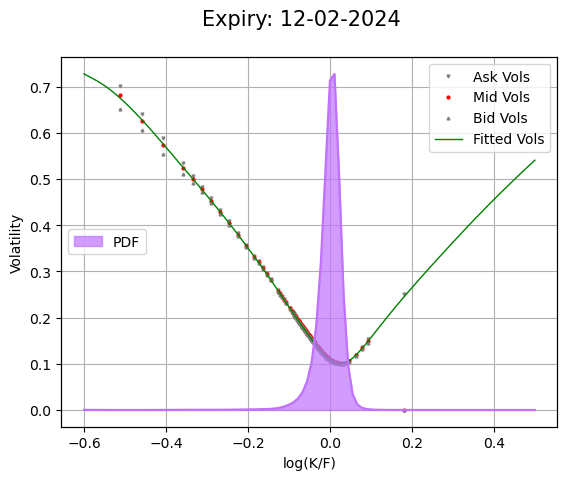

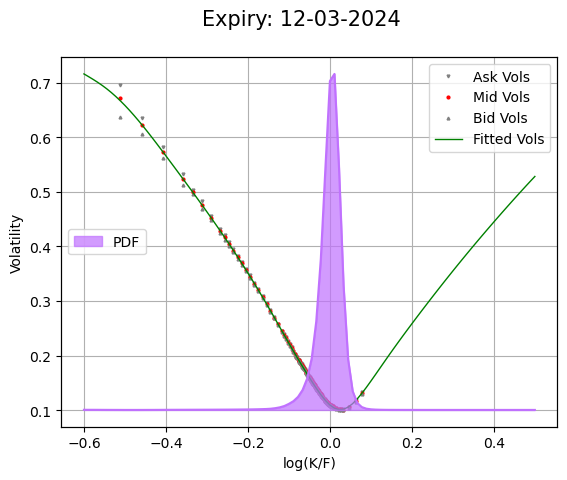

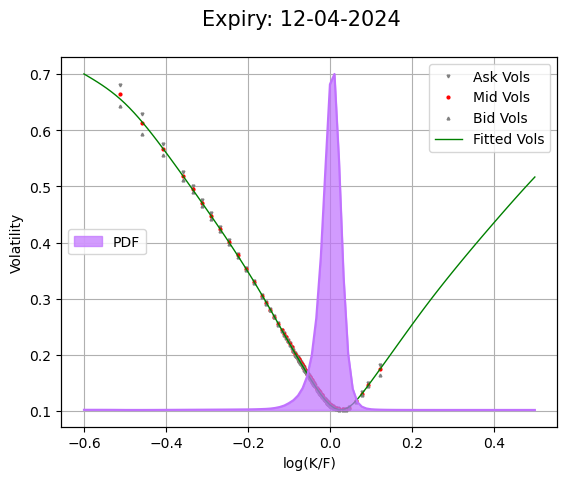

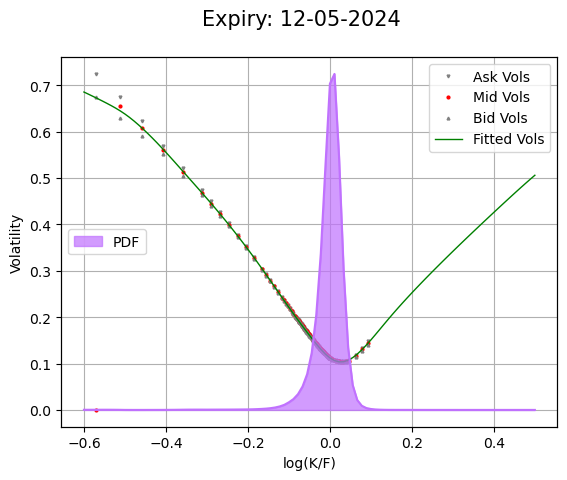

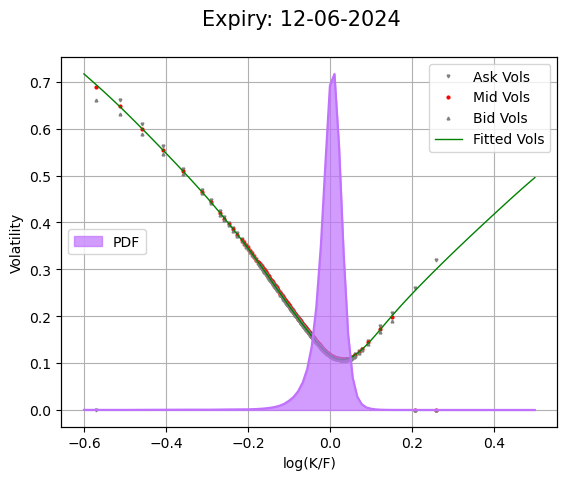

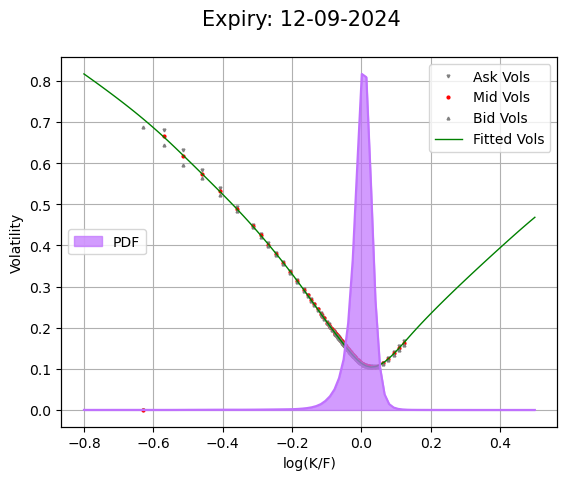

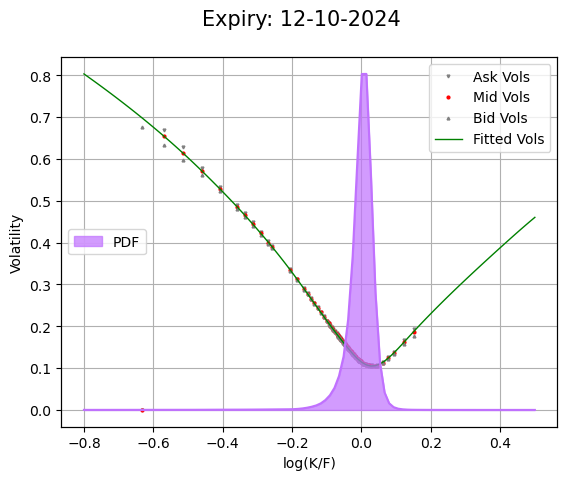

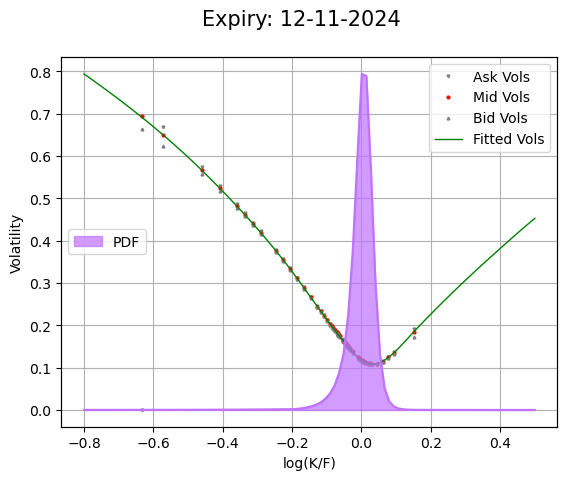

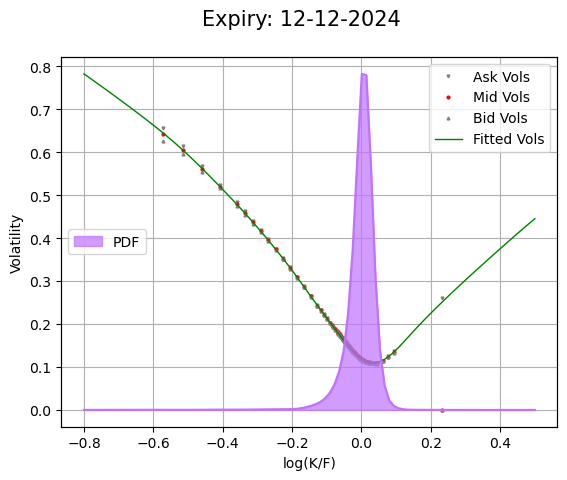

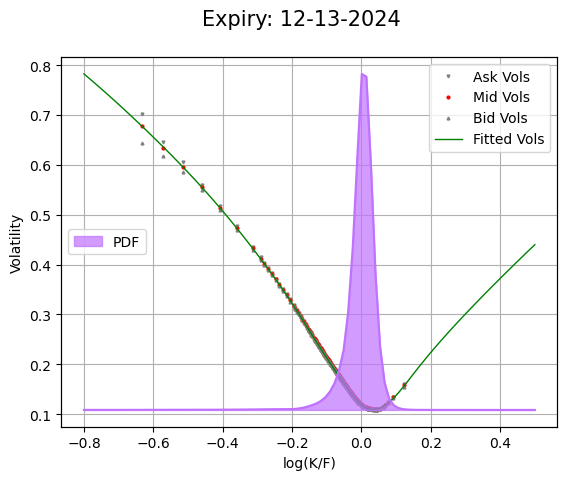

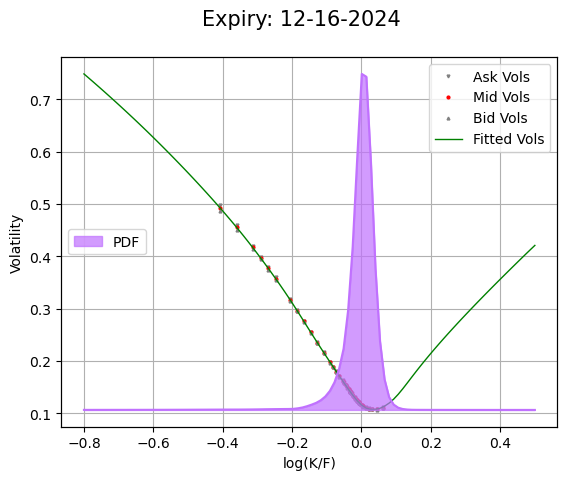

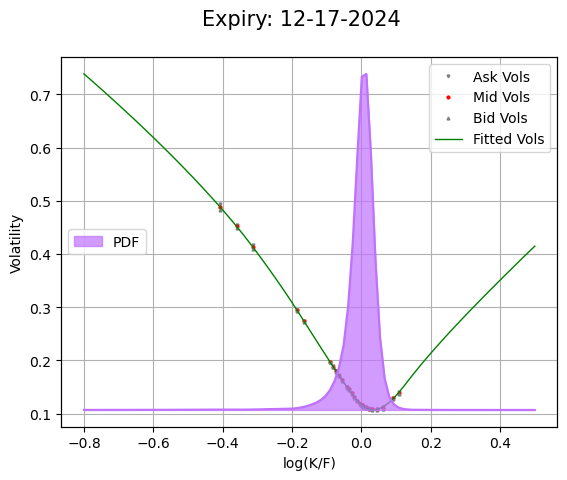

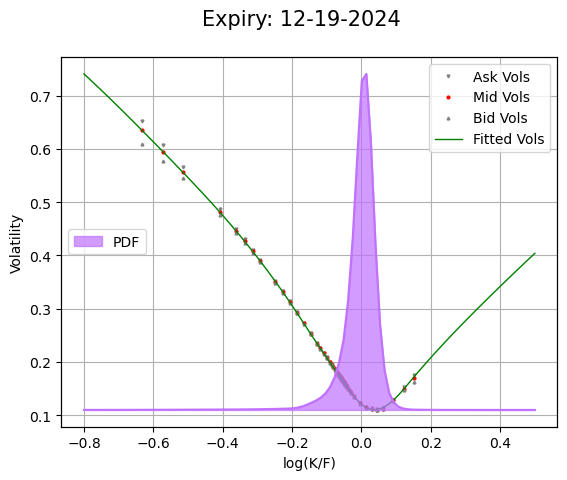

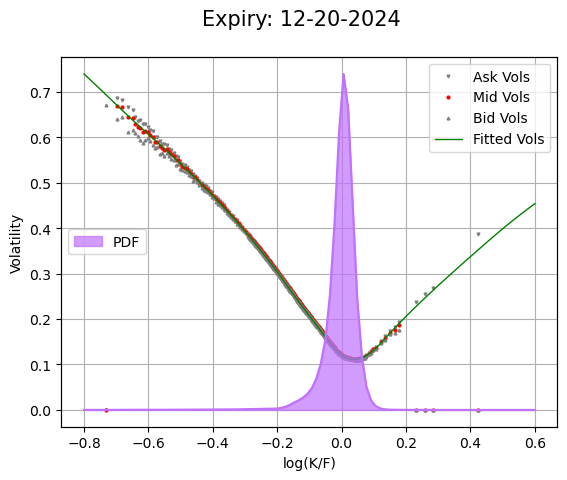

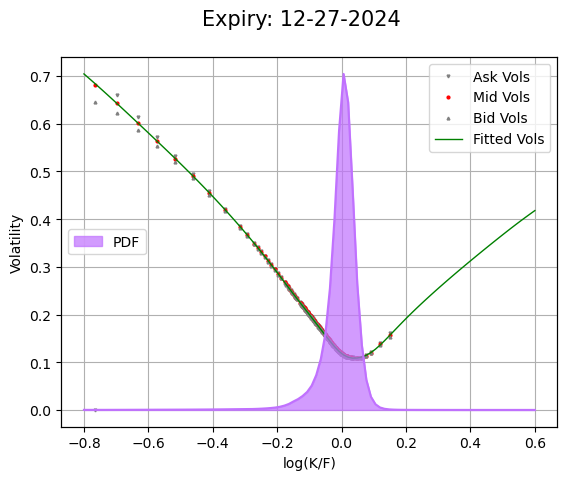

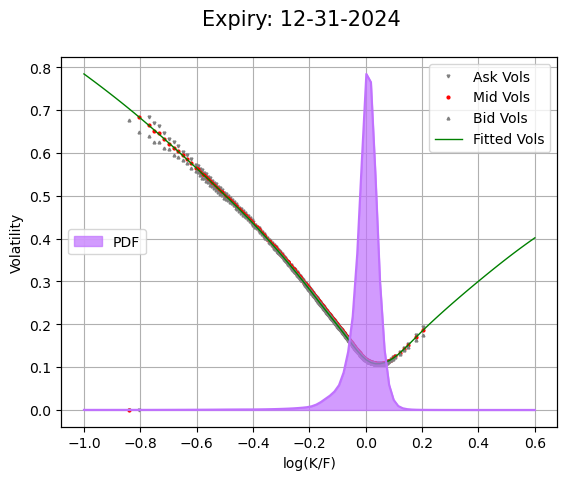

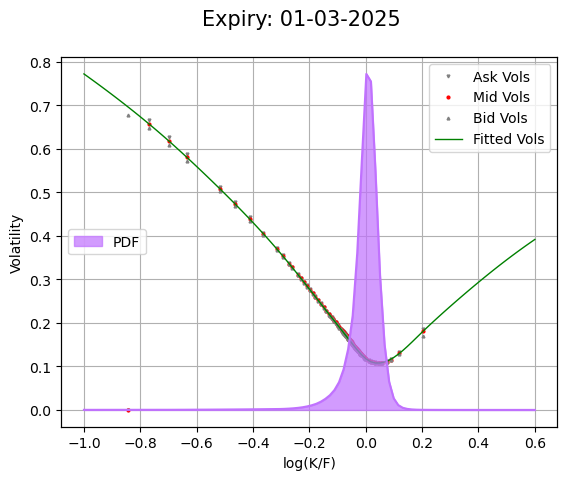

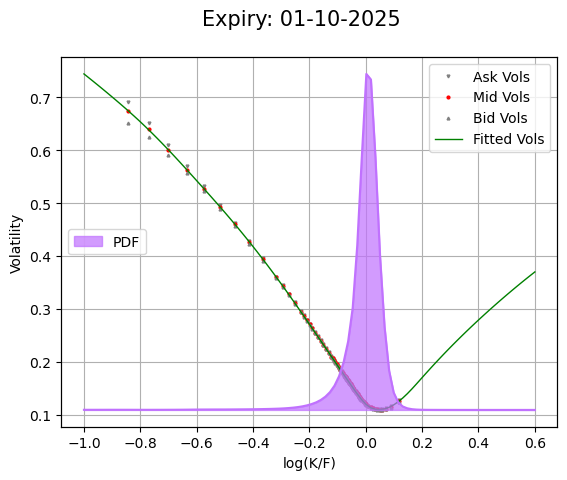

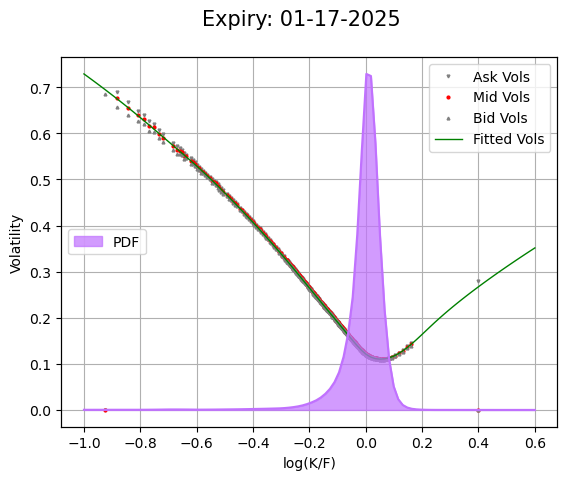

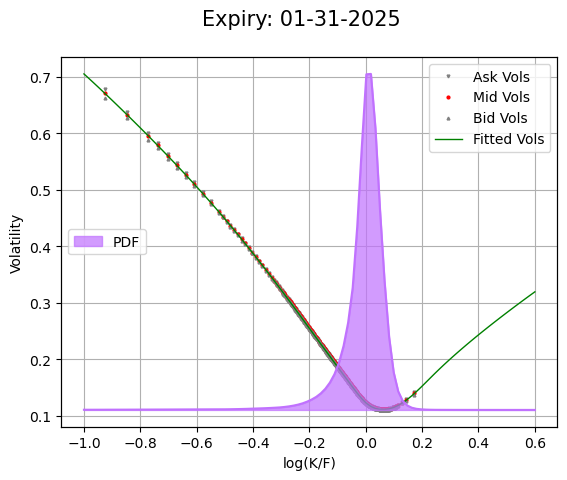

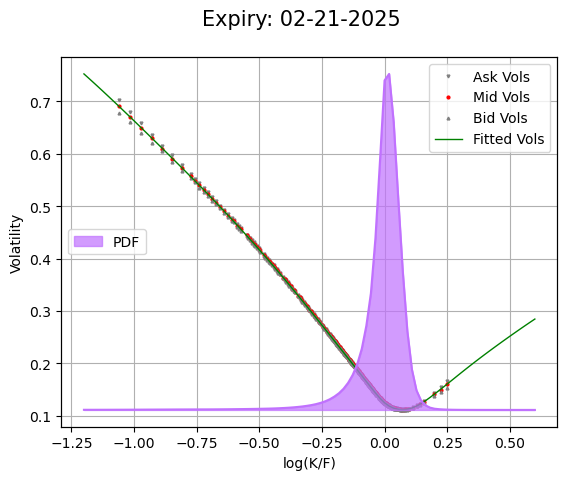

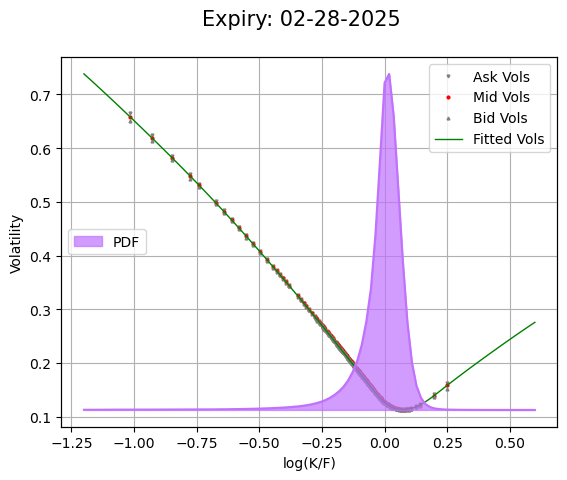

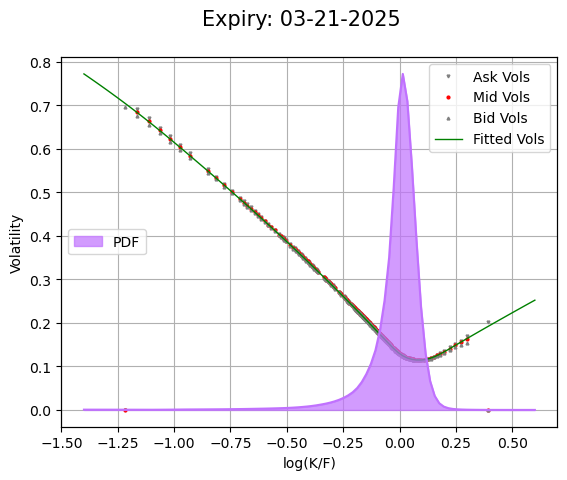

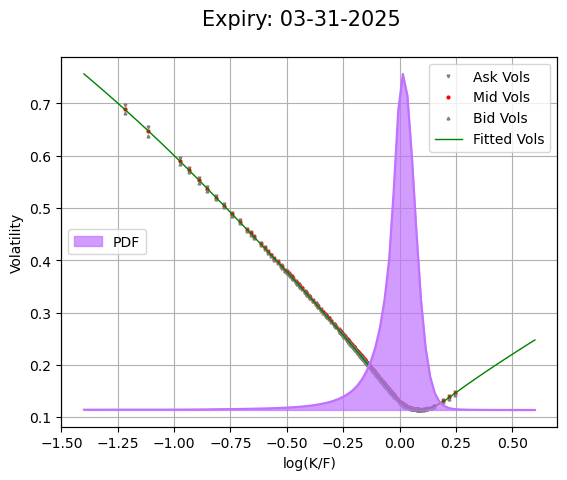

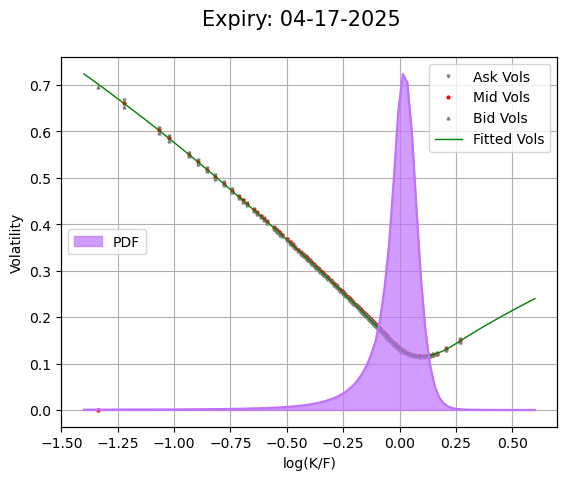

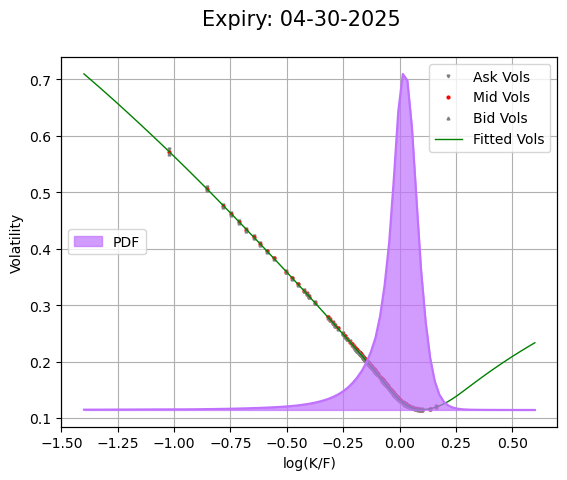

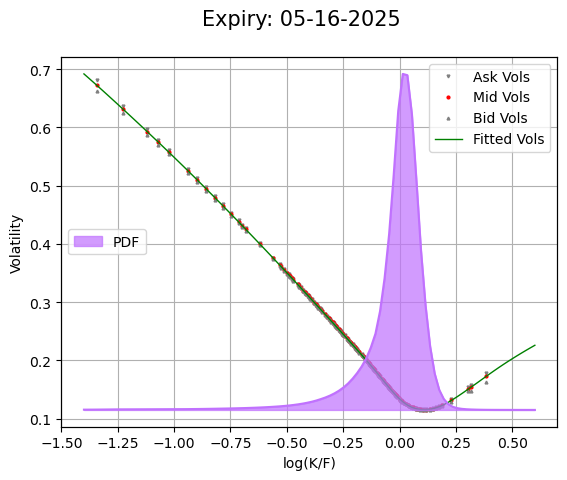

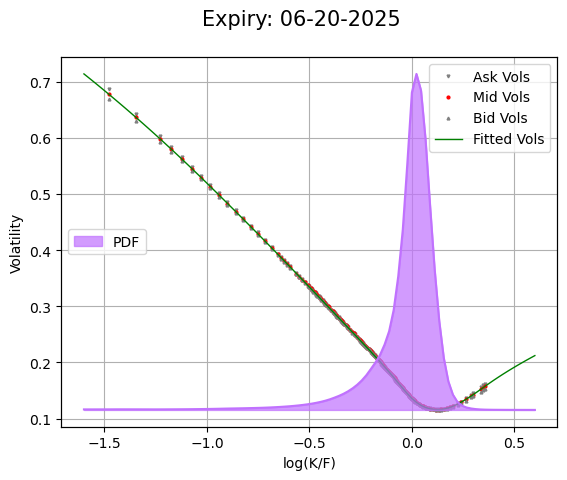

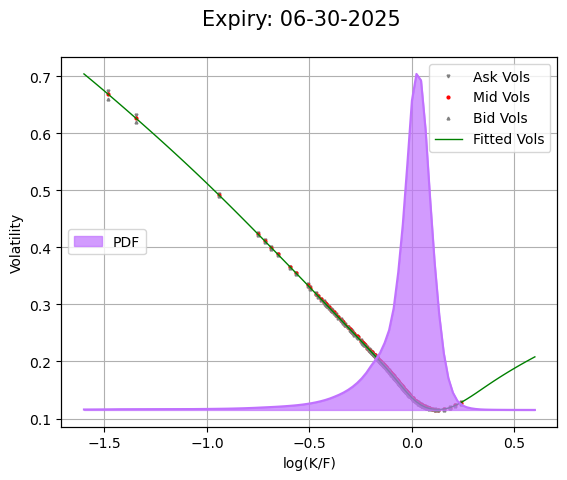

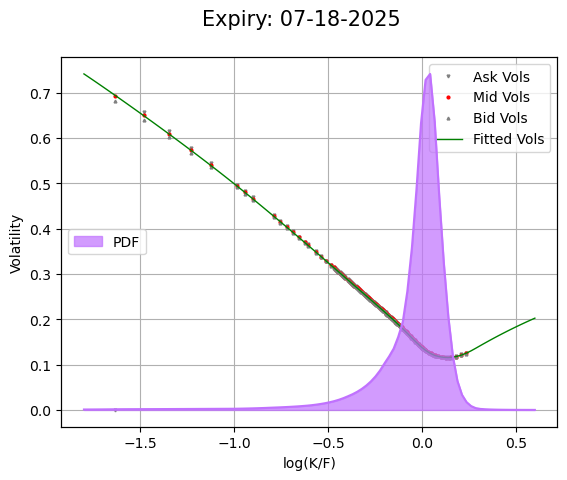

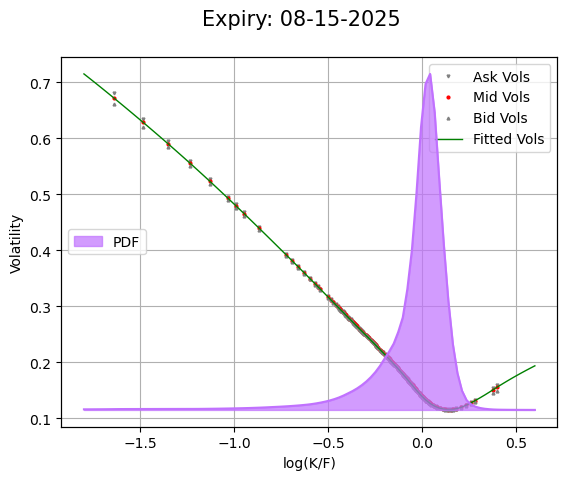

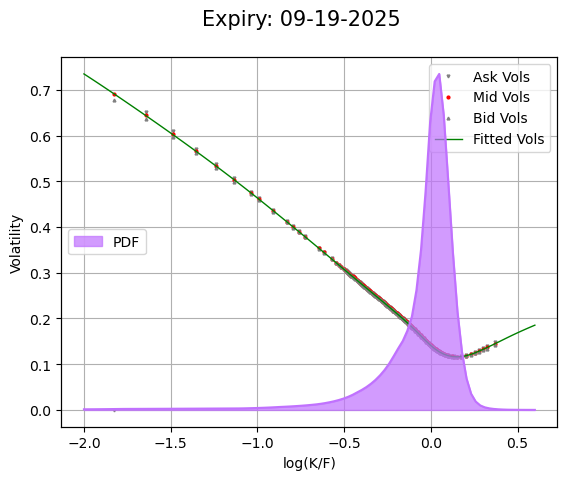

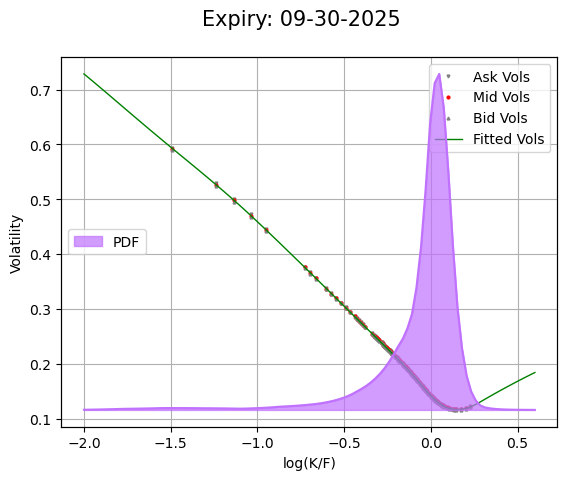

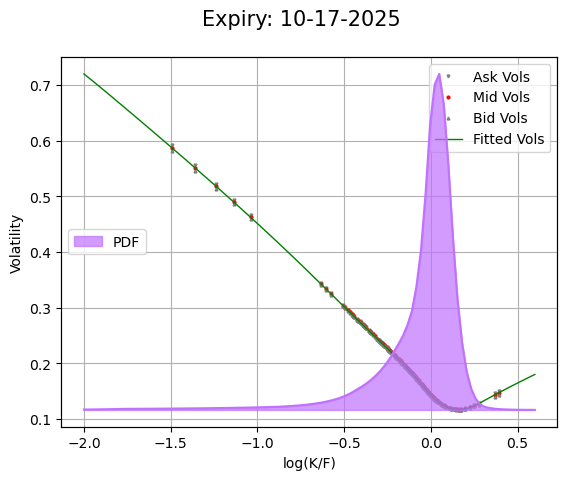

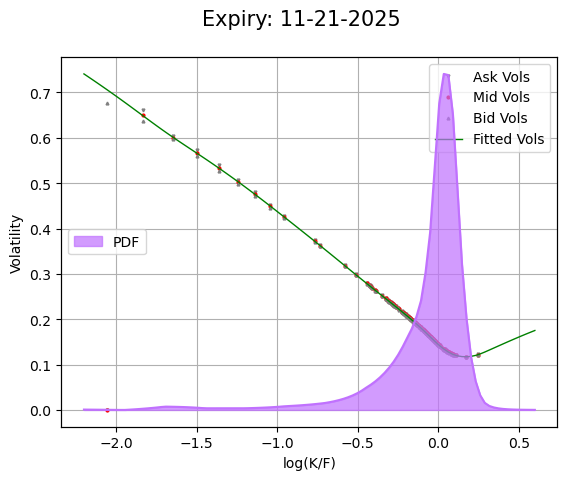

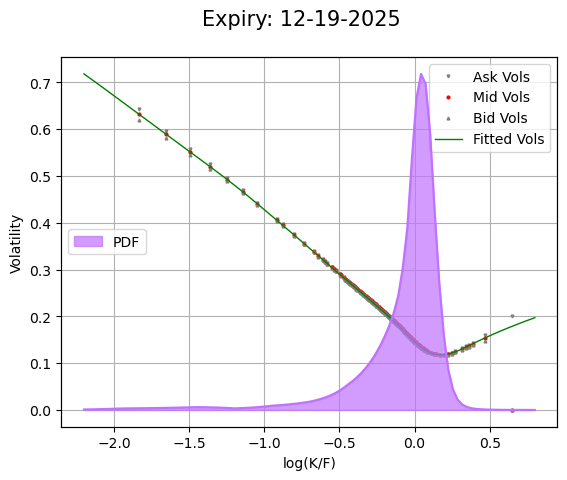

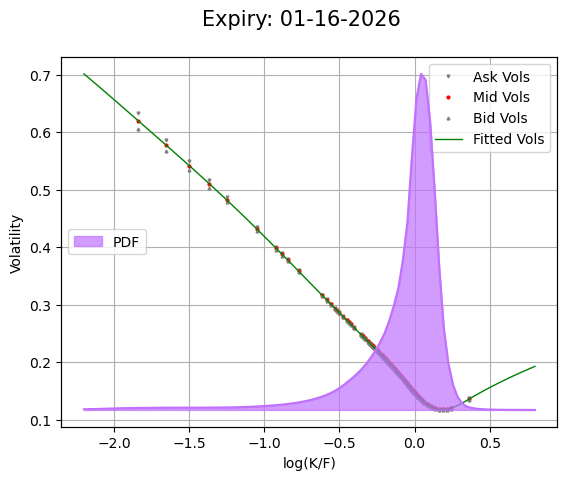

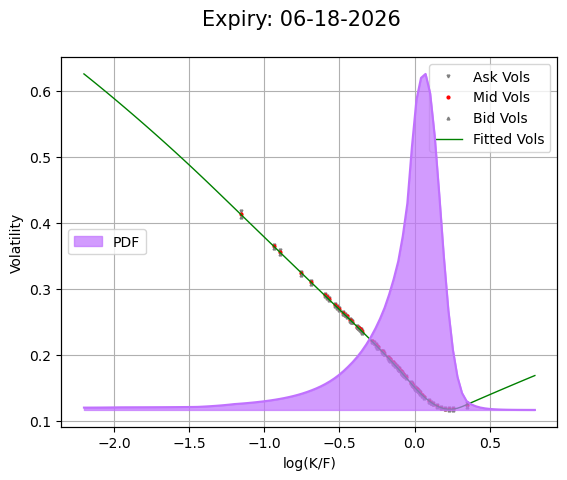

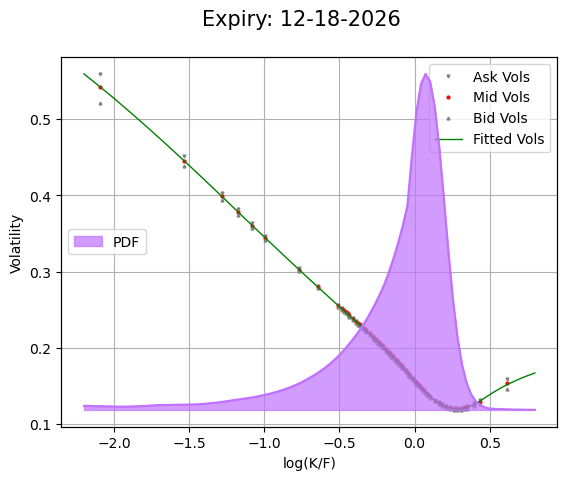

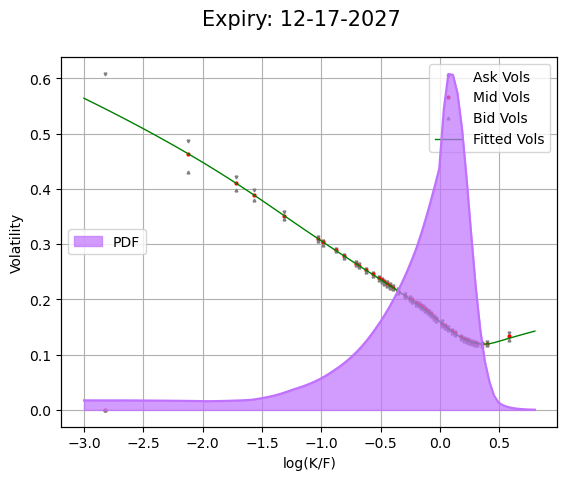

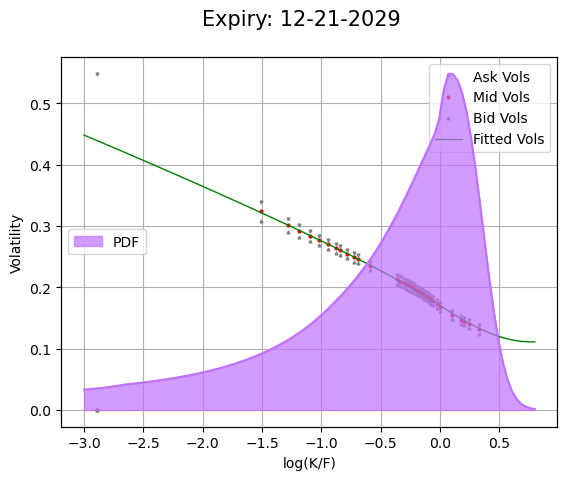

In [33]:
volFitter.plot_surface_and_pdf()

## __References__

1. Deschâtres, Fabrice, Convex Volatility Interpolation (May 26, 2024). Available at SSRN: https://ssrn.com/abstract=4831218 or http://dx.doi.org/10.2139/ssrn.4831218